In [2]:
import ezc3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=4):
    """Zero-lag Butterworth low-pass filter."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def calculate_3d_angle(A, B, C):
    """
    Calculate angle ABC in 3D space (angle at point B).
    Formula: arccos((BA . BC) / (|BA| * |BC|))
    """
    BA = A - B
    BC = C - B
    
    dot_product = np.sum(BA * BC, axis=0)
    mag_BA = np.sqrt(np.sum(BA**2, axis=0))
    mag_BC = np.sqrt(np.sum(BC**2, axis=0))
    
    # Avoid division by zero
    mag_product = mag_BA * mag_BC
    mag_product[mag_product == 0] = 1e-10
    
    cos_angle = dot_product / mag_product
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    
    return np.degrees(np.arccos(cos_angle))

def calculate_sagittal_angle(A, B, C):
    """Calculate angle projected onto the Sagittal plane (X-Z)."""
    A_sag = np.array([A[0, :], A[2, :]])
    B_sag = np.array([B[0, :], B[2, :]])
    C_sag = np.array([C[0, :], C[2, :]])
    # Re-use the 3D logic on 2D vectors
    return calculate_3d_angle(A_sag, B_sag, C_sag)

In [3]:
def load_c3d_file(filename):
    """Loads C3D and returns points, labels, and frame rate."""
    try:
        c = ezc3d.c3d(filename)
        points = c['data']['points']
        labels = [str(l).strip() for l in c['parameters']['POINT']['LABELS']['value']]
        rate = c['parameters']['POINT']['RATE']['value'][0]
        print(f"Loaded {filename} ({rate} Hz). Found {len(labels)} labels.")
        return points, labels, rate
    except Exception as e:
        print(f"Error loading file: {e}")
        return None, None, None

def extract_marker_trajectory(points, labels, target_names):
    """Extracts specific marker data, handling aliases and NaNs."""
    if isinstance(target_names, str): target_names = [target_names]
    
    indices = [labels.index(name) for name in target_names if name in labels]
    
    if not indices:
        # print(f"Warning: Markers {target_names} not found.") # Optional verbosity
        return None

    # Average if multiple markers define a point (e.g. 4 head markers)
    data = np.mean(points[0:3, indices, :], axis=1)
    data[data == 0] = np.nan
    
    # Interpolate small NaN gaps
    for axis in range(3):
        y = data[axis, :]
        nans, x = np.isnan(y), lambda z: z.nonzero()[0]
        if nans.any() and (~nans).any():
            y[nans] = np.interp(x(nans), x(~nans), y[~nans])
            data[axis, :] = y
            
    return data

def get_anatomical_markers(points, labels):
    """
    Batch extracts all relevant body parts into a dictionary.
    Add or remove marker aliases here.
    """
    markers = {}
    # Lower Body
    markers['L_heel'] = extract_marker_trajectory(points, labels, ['LHEE', 'L.Heel', 'LANK'])
    markers['R_heel'] = extract_marker_trajectory(points, labels, ['RHEE', 'R.Heel', 'RANK'])
    markers['Pelvis'] = extract_marker_trajectory(points, labels, ['LASI', 'RASI', 'LPSI', 'RPSI', 'PELVIS'])
    
    # Joints for Angles
    markers['L_hip'] = extract_marker_trajectory(points, labels, ['LASI', 'L.Hip', 'LGT'])
    markers['R_hip'] = extract_marker_trajectory(points, labels, ['RASI', 'R.Hip', 'RGT'])
    markers['L_knee'] = extract_marker_trajectory(points, labels, ['LKNE', 'L.Knee', 'LKNEE'])
    markers['R_knee'] = extract_marker_trajectory(points, labels, ['RKNE', 'R.Knee', 'RKNEE'])
    markers['L_ankle'] = extract_marker_trajectory(points, labels, ['LANK', 'L.Ankle', 'LANKLE'])
    markers['R_ankle'] = extract_marker_trajectory(points, labels, ['RANK', 'R.Ankle', 'RANKLE'])
    markers['L_toe'] = extract_marker_trajectory(points, labels, ['LTOE', 'L.Toe', 'LMT5'])
    markers['R_toe'] = extract_marker_trajectory(points, labels, ['RTOE', 'R.Toe', 'RMT5'])
    
    # Upper Body
    markers['L_shoulder'] = extract_marker_trajectory(points, labels, ['LACR', 'L.Shoulder', 'LSHO'])
    markers['R_shoulder'] = extract_marker_trajectory(points, labels, ['RACR', 'R.Shoulder', 'RSHO'])
    markers['L_elbow'] = extract_marker_trajectory(points, labels, ['LELB', 'L.Elbow'])
    markers['R_elbow'] = extract_marker_trajectory(points, labels, ['RELB', 'R.Elbow'])
    markers['L_wrist'] = extract_marker_trajectory(points, labels, ['LWRA', 'L.Wrist', 'LWRB'])
    markers['R_wrist'] = extract_marker_trajectory(points, labels, ['RWRA', 'R.Wrist', 'RWRB'])
    
    return markers

In [4]:
def detect_running_mode(pelvis_data, running_type_input='auto'):
    """Determines if running is Treadmill or Overground based on displacement."""
    if running_type_input != 'auto':
        return running_type_input
    
    pelvis_y = pelvis_data[1, :]
    total_travel = np.max(pelvis_y) - np.min(pelvis_y)
    
    if total_travel < 1000: # Less than 1 meter travel
        return 'treadmill'
    return 'overground'

def detect_heel_strikes(heel_l, heel_r, rate):
    """
    Detects heel strikes using vertical acceleration peaks.
    Returns indices of Left and Right heel strikes.
    """
    z_idx = 2
    cutoff_pos, cutoff_acc = 10, 6
    
    # Filter position
    l_z = butter_lowpass_filter(heel_l[z_idx, :], cutoff_pos, rate)
    r_z = butter_lowpass_filter(heel_r[z_idx, :], cutoff_pos, rate)
    
    # Calculate Acceleration (double derivative)
    l_acc = np.gradient(np.gradient(l_z, 1/rate), 1/rate)
    r_acc = np.gradient(np.gradient(r_z, 1/rate), 1/rate)
    
    # Filter Acceleration
    l_acc_filt = butter_lowpass_filter(l_acc, cutoff_acc, rate)
    r_acc_filt = butter_lowpass_filter(r_acc, cutoff_acc, rate)
    
    # Floor estimation
    floor_z = np.min(np.concatenate([l_z, r_z]))
    min_dist = int(rate * 0.25) # 250ms min spacing
    
    # Find Peaks
    hs_l, _ = find_peaks(l_acc_filt, height=np.std(l_acc_filt), distance=min_dist, prominence=np.std(l_acc_filt)*0.5)
    hs_r, _ = find_peaks(r_acc_filt, height=np.std(r_acc_filt), distance=min_dist, prominence=np.std(r_acc_filt)*0.5)
    
    # Validation: Heel must be near floor
    hs_l = hs_l[l_z[hs_l] < floor_z + 100]
    hs_r = hs_r[r_z[hs_r] < floor_z + 100]
    
    return hs_l, hs_r

In [5]:
def compute_kinematics(markers):
    """Computes joint angle time series."""
    angles = {}
    
    # 1. Sagittal Lower Body
    if all(k in markers and markers[k] is not None for k in ['L_hip', 'L_knee', 'L_ankle']):
        angles['knee_left'] = calculate_sagittal_angle(markers['L_hip'], markers['L_knee'], markers['L_ankle'])
    if all(k in markers and markers[k] is not None for k in ['L_shoulder', 'L_hip', 'L_knee']):
        angles['hip_left'] = calculate_sagittal_angle(markers['L_shoulder'], markers['L_hip'], markers['L_knee'])
    
    # Mirror for Right side...
    if all(k in markers and markers[k] is not None for k in ['R_hip', 'R_knee', 'R_ankle']):
        angles['knee_right'] = calculate_sagittal_angle(markers['R_hip'], markers['R_knee'], markers['R_ankle'])
    if all(k in markers and markers[k] is not None for k in ['R_shoulder', 'R_hip', 'R_knee']):
        angles['hip_right'] = calculate_sagittal_angle(markers['R_shoulder'], markers['R_hip'], markers['R_knee'])

    # 2. Trunk Lean
    # Vector from hip center to shoulder center vs Vertical
    if all(k in markers and markers[k] is not None for k in ['L_shoulder', 'R_shoulder', 'Pelvis']):
        shoulder_center = (markers['L_shoulder'] + markers['R_shoulder']) / 2
        trunk_vec = shoulder_center - markers['Pelvis']
        vert_vec = np.array([[0], [0], [1]])
        
        # simplified dot product approach for lean
        dot = np.sum(trunk_vec * vert_vec, axis=0)
        mags = np.sqrt(np.sum(trunk_vec**2, axis=0))
        angles['trunk_lean'] = 90 - np.degrees(np.arccos(np.clip(dot/mags, -1, 1)))

    return angles

In [16]:
def calculate_metrics(markers, hs_l, hs_r, rate, running_type):
    """Calculates scalar metrics like speed, cadence, and vertical oscillation."""
    
    # 1. Cadence
    total_steps = len(hs_l) + len(hs_r)
    duration_min = markers['Pelvis'].shape[1] / rate / 60
    cadence = total_steps / duration_min
    
    # 2. Vertical Oscillation
    pelvis_z = butter_lowpass_filter(markers['Pelvis'][2, :], 5, rate)
    oscillations = []
    all_hs = np.sort(np.concatenate([hs_l, hs_r]))
    for i in range(len(all_hs)-1):
        if all_hs[i+1] - all_hs[i] > int(0.3 * rate):
            segment = pelvis_z[all_hs[i]:all_hs[i+1]]
            oscillations.append(np.max(segment) - np.min(segment))
    vert_osc = np.mean(oscillations) if oscillations else 0
    
    # 3. Speed & Stride Length
    pelvis_vel_y = np.gradient(butter_lowpass_filter(markers['Pelvis'][1, :], 5, rate), 1/rate)
    
    speed_curve = np.zeros_like(pelvis_vel_y)
    avg_speed_kph = 0
    stride_len = 0


    if running_type == 'treadmill':
        # Estimate belt speed during stance phase (approx logic)
        # stance_vels = []
        # for hs in np.concatenate([hs_l, hs_r]):
        #     idx = hs + int(0.15 * rate) # Mid-stance
        #     if idx < len(pelvis_vel_y):
        #         stance_vels.append(pelvis_vel_y[idx])
        
        # belt_speed = -np.median(stance_vels) if stance_vels else 3000
        # speed_curve = belt_speed + pelvis_vel_y
        # avg_speed_kph = (belt_speed / 1000) * 3.6
        
        # # Treadmill Stride Length
        # cycle_time = np.mean(np.diff(hs_l)) / rate if len(hs_l) > 1 else 0
        # stride_len = (avg_speed_kph / 3.6) * cycle_time

        # Calculate Heel Velocity in Y direction
        heel_l_vel = np.gradient(butter_lowpass_filter(markers['L_heel'][1, :], 10, rate), 1/rate)
        heel_r_vel = np.gradient(butter_lowpass_filter(markers['R_heel'][1, :], 10, rate), 1/rate)
        
        measured_belt_speeds = []

        # Check Left Foot Stance Velocities
        for hs in hs_l:
            # Look at window 100ms to 200ms AFTER heel strike (Mid-Stance)
            # The foot should be moving backwards steadily here
            start = hs + int(0.10 * rate) 
            end = hs + int(0.25 * rate)
            
            if end < len(heel_l_vel):
                # Velocity is negative (moving back), so we take -mean
                v_stance = np.mean(heel_l_vel[start:end])
                measured_belt_speeds.append(-v_stance)

        # Check Right Foot Stance Velocities (for more data points)
        for hs in hs_r:
            start = hs + int(0.10 * rate)
            end = hs + int(0.25 * rate)
            if end < len(heel_r_vel):
                v_stance = np.mean(heel_r_vel[start:end])
                measured_belt_speeds.append(-v_stance)
        
        if measured_belt_speeds:
            belt_speed_mm_s = np.median(measured_belt_speeds)

            print(f"Detected Belt Speed: {belt_speed_mm_s:.2f} mm/s ({(belt_speed_mm_s/1000)*3.6:.2f} km/h)")
        else:
            print("Warning: Could not detect belt speed. Defaulting to 10 km/h")
            belt_speed_mm_s = 2777.7 # ~10kph fallback

        # Subject Speed = Belt Speed + Pelvis fluctuation
        speed_curve = belt_speed_mm_s + pelvis_vel_y
        avg_speed_kph = (belt_speed_mm_s / 1000) * 3.6
        
        # Treadmill Stride Length calculation
        # Cycle time = Average time between steps (Left to Left)
        if len(hs_l) > 1:
            avg_cycle_time_s = np.mean(np.diff(hs_l)) / rate
            # Stride Length = Speed (m/s) * Cycle Time (s)
            stride_len = (belt_speed_mm_s / 1000) * avg_cycle_time_s
        
    else: # Overground
        speed_curve = butter_lowpass_filter(pelvis_vel_y, 1, rate)
        # Take middle 50% to avoid start/stop
        mid_slice = slice(int(0.25*len(speed_curve)), int(0.75*len(speed_curve)))
        avg_speed_kph = (np.mean(speed_curve[mid_slice]) / 1000) * 3.6
        
        # Overground Stride Length
        stride_times = np.diff(all_hs) / rate
        stride_len = (avg_speed_kph / 3.6) * np.mean(stride_times) if len(stride_times) > 0 else 0

    return {
        'cadence': cadence,
        'vert_osc_mm': vert_osc,
        'avg_speed_kph': avg_speed_kph,
        'stride_len_m': stride_len,
        'speed_curve_kph': (speed_curve/1000)*3.6,
        'running_type': running_type
    }

Loaded CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Fast\Post_Process\Treadmill_Run_Fast.c3d (100.0 Hz). Found 206 labels.
Detected Mode: TREADMILL
Steps: L=166, R=165
Detected Belt Speed: -444.08 mm/s (-1.60 km/h)

--- RESULTS ---
Cadence: 147.5 spm
Speed:   -1.60 km/h
Stride:  -0.16 m
V. Osc:  83.5 mm


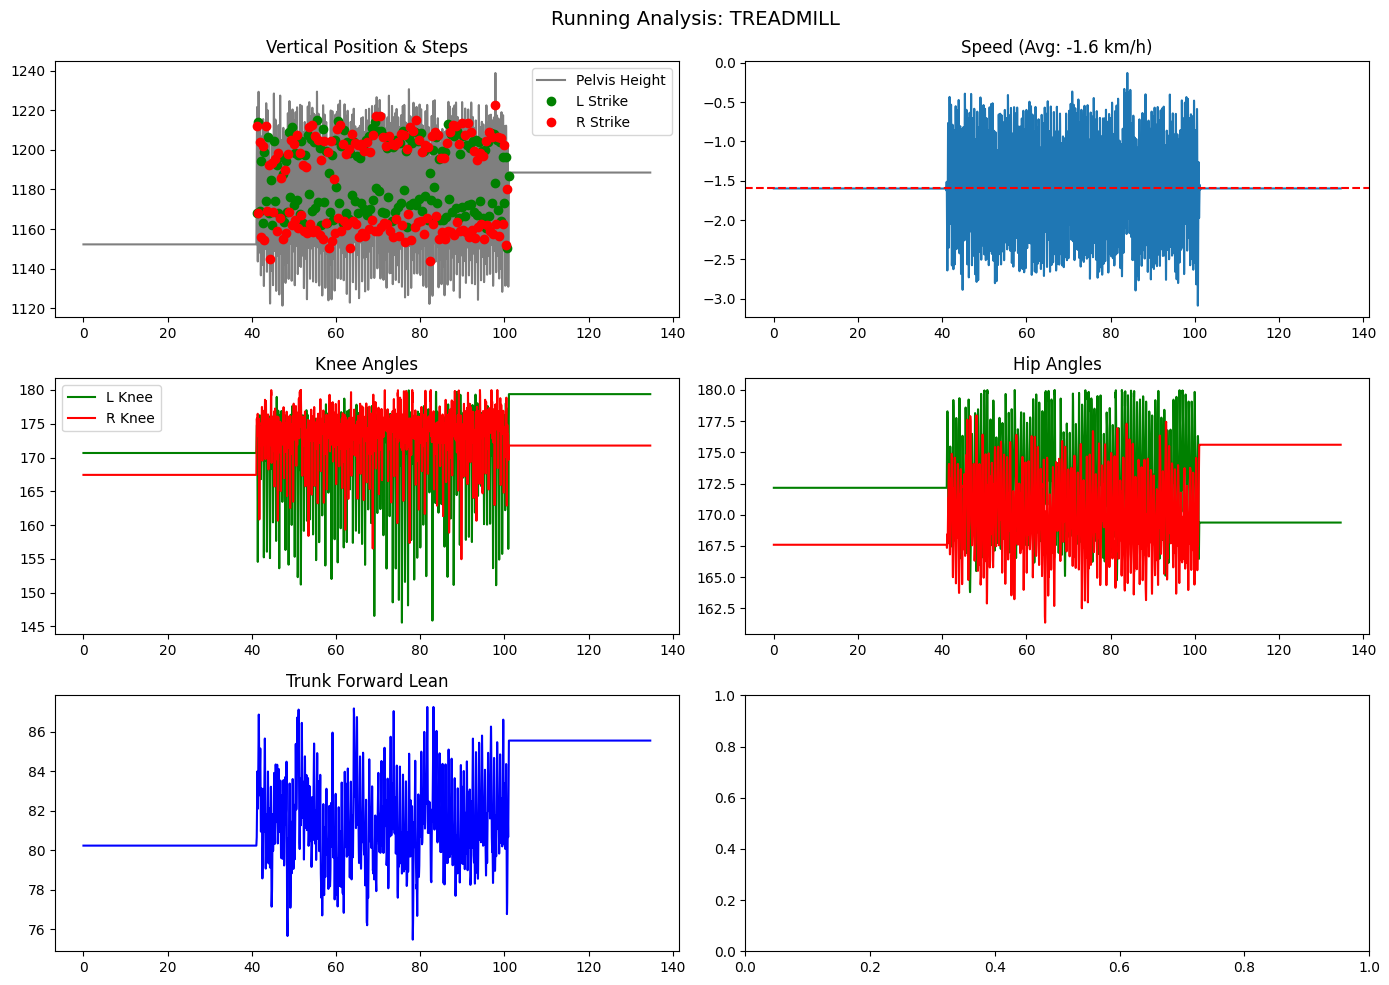

In [17]:
def visualize_results(t, angles, metrics, markers, hs_l, hs_r):
    """Generates the summary plot."""
    fig, axs = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f"Running Analysis: {metrics['running_type'].upper()}", fontsize=14)
    
    # 1. Vertical Position (Steps)
    pelvis_z = markers['Pelvis'][2,:]
    axs[0,0].plot(t, pelvis_z, 'k-', alpha=0.5, label='Pelvis Height')
    axs[0,0].plot(t[hs_l], pelvis_z[hs_l], 'go', label='L Strike')
    axs[0,0].plot(t[hs_r], pelvis_z[hs_r], 'ro', label='R Strike')
    axs[0,0].set_title('Vertical Position & Steps')
    axs[0,0].legend()
    
    # 2. Speed
    axs[0,1].plot(t, metrics['speed_curve_kph'])
    axs[0,1].axhline(metrics['avg_speed_kph'], color='r', linestyle='--')
    axs[0,1].set_title(f"Speed (Avg: {metrics['avg_speed_kph']:.1f} km/h)")
    
    # 3. Knees
    if 'knee_left' in angles: axs[1,0].plot(t, angles['knee_left'], 'g', label='L Knee')
    if 'knee_right' in angles: axs[1,0].plot(t, angles['knee_right'], 'r', label='R Knee')
    axs[1,0].set_title('Knee Angles')
    axs[1,0].legend()
    
    # 4. Hips
    if 'hip_left' in angles: axs[1,1].plot(t, angles['hip_left'], 'g', label='L Hip')
    if 'hip_right' in angles: axs[1,1].plot(t, angles['hip_right'], 'r', label='R Hip')
    axs[1,1].set_title('Hip Angles')
    
    # 5. Trunk
    if 'trunk_lean' in angles: 
        axs[2,0].plot(t, angles['trunk_lean'], 'b')
        axs[2,0].set_title('Trunk Forward Lean')

    plt.tight_layout()
    plt.show()

def run_analysis_pipeline(filename, running_mode='auto'):
    """Main Orchestrator Function."""
    
    # 1. Load
    points, labels, rate = load_c3d_file(filename)
    if points is None: return
    
    # 2. Extract Markers
    markers = get_anatomical_markers(points, labels)
    if markers['Pelvis'] is None or markers['L_heel'] is None:
        print("Critical markers missing.")
        return

    # 3. Event Detection
    r_type = detect_running_mode(markers['Pelvis'], running_mode)
    print(f"Detected Mode: {r_type.upper()}")
    
    hs_l, hs_r = detect_heel_strikes(markers['L_heel'], markers['R_heel'], rate)
    print(f"Steps: L={len(hs_l)}, R={len(hs_r)}")
    
    if len(hs_l) < 2: 
        print("Not enough steps for analysis.")
        return

    # 4. Calculations
    angles = compute_kinematics(markers)
    metrics = calculate_metrics(markers, hs_l, hs_r, rate, r_type)
    
    # 5. Report
    print("\n--- RESULTS ---")
    print(f"Cadence: {metrics['cadence']:.1f} spm")
    print(f"Speed:   {metrics['avg_speed_kph']:.2f} km/h")
    print(f"Stride:  {metrics['stride_len_m']:.2f} m")
    print(f"V. Osc:  {metrics['vert_osc_mm']:.1f} mm")
    
    # 6. Visualize
    t = np.arange(points.shape[2]) / rate
    visualize_results(t, angles, metrics, markers, hs_l, hs_r)

# --- EXECUTION ---
if __name__ == "__main__":
    # Update path as needed
    # file_path = 'CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Treadmill_Run\\Treadmill_Run_Comfortable\\Post_Process\\Treadmill_Run_Comfortable.c3d' 
    file_path = 'CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Treadmill_Run\\Treadmill_Run_Fast\\Post_Process\\Treadmill_Run_Fast.c3d' 
    # file_path = 'CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Overground_Run\\Run_Comfortable\\Post_Process\\Run_Comfortable1.c3d' 
    run_analysis_pipeline(file_path, running_mode='auto')

Start

In [18]:
data = pd.read_csv("running_biomechanics_results.csv")

In [19]:
data.head()

,Subject_ID,Gender,Session,Condition,Filename,Running_Type,Avg_Speed_kmh,Cadence_spm,Stride_Length_m,Vert_Oscillation_mm,...,Left_Knee_Mean,Right_Knee_Mean,Left_Hip_Mean,Right_Hip_Mean,Left_Ankle_Mean,Right_Ankle_Mean,Left_Elbow_Mean,Right_Elbow_Mean,Trunk_Lean_Mean,Pelvic_Tilt_Mean
0,AJ026,F,Session_1,Run_Comfortable,Run_Comfortable1.c3d,overground,9.13,218.750000,0.469176,84.037641,...,171.0,167.0,165.1,164.2,130.0,126.2,89.7,110.5,81.7,-0.9
1,AJ026,F,Session_1,Run_Comfortable,Run_Comfortable10.c3d,overground,-8.16,287.425150,-0.356339,62.119560,...,169.0,169.3,164.8,165.0,135.4,120.4,86.3,98.3,82.6,-0.1
2,AJ026,F,Session_1,Run_Comfortable,Run_Comfortable2.c3d,overground,-8.71,341.772152,-0.417281,68.604926,...,169.8,169.7,164.0,165.1,132.3,121.3,87.1,109.8,84.2,-0.1
3,AJ026,F,Session_1,Run_Comfortable,Run_Comfortable3.c3d,overground,8.74,287.234043,0.443289,84.049918,...,169.2,169.1,163.9,165.8,129.4,130.9,81.6,97.0,82.3,0.4
4,AJ026,F,Session_1,Run_Comfortable,Run_Comfortable4.c3d,overground,-9.27,269.662921,-0.408144,72.455964,...,168.0,170.2,163.7,166.0,130.5,123.8,85.3,99.7,83.2,0.8


In [20]:
data.shape 

(698, 21)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9220\3844280423.py:41: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df, x='Condition', y=col, hue='Gender', ax=ax, dodge=True, color='black', alpha=0.3, legend=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9220\3844280423.py:41: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df, x='Condition', y=col, hue='Gender', ax=ax, dodge=True, color='black', alpha=0.3, legend=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9220\3844280423.py:41: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df, x='Condition', y=col, hue='Gender', ax=ax, dodge=True, color='black', alpha=0.

Generated: group_analysis_boxplots.png


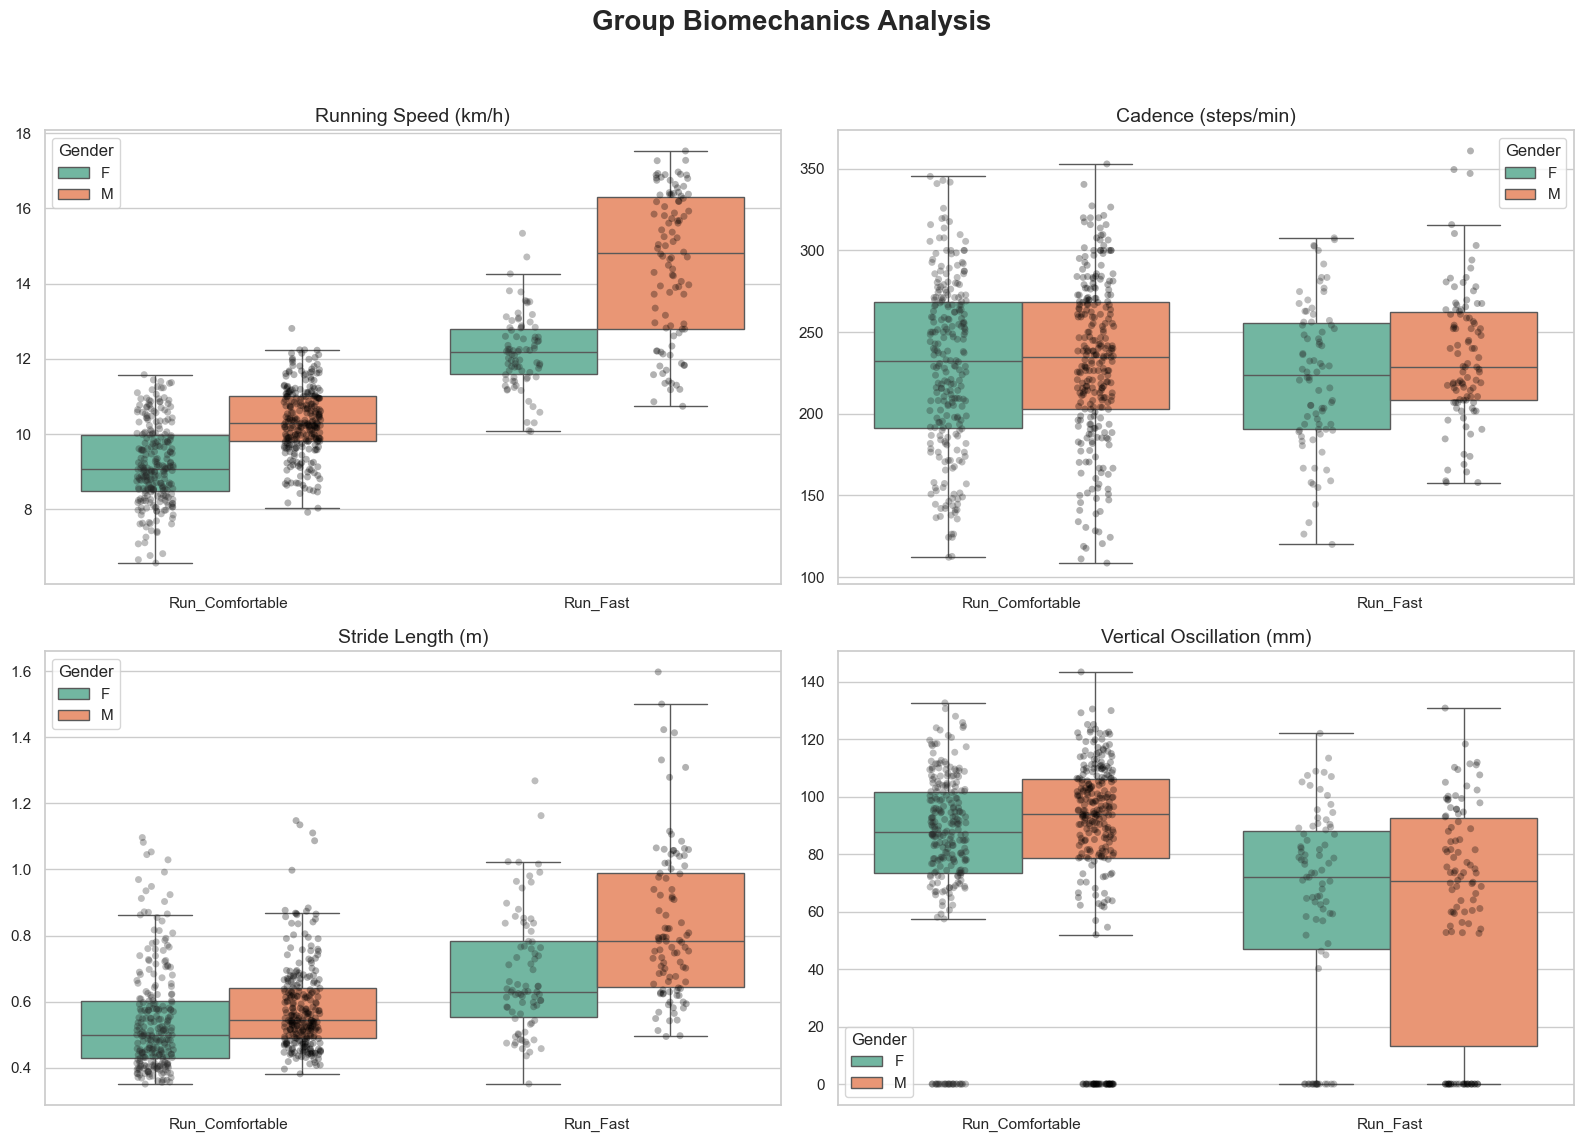

Generated: subject_DC005_dashboard.png


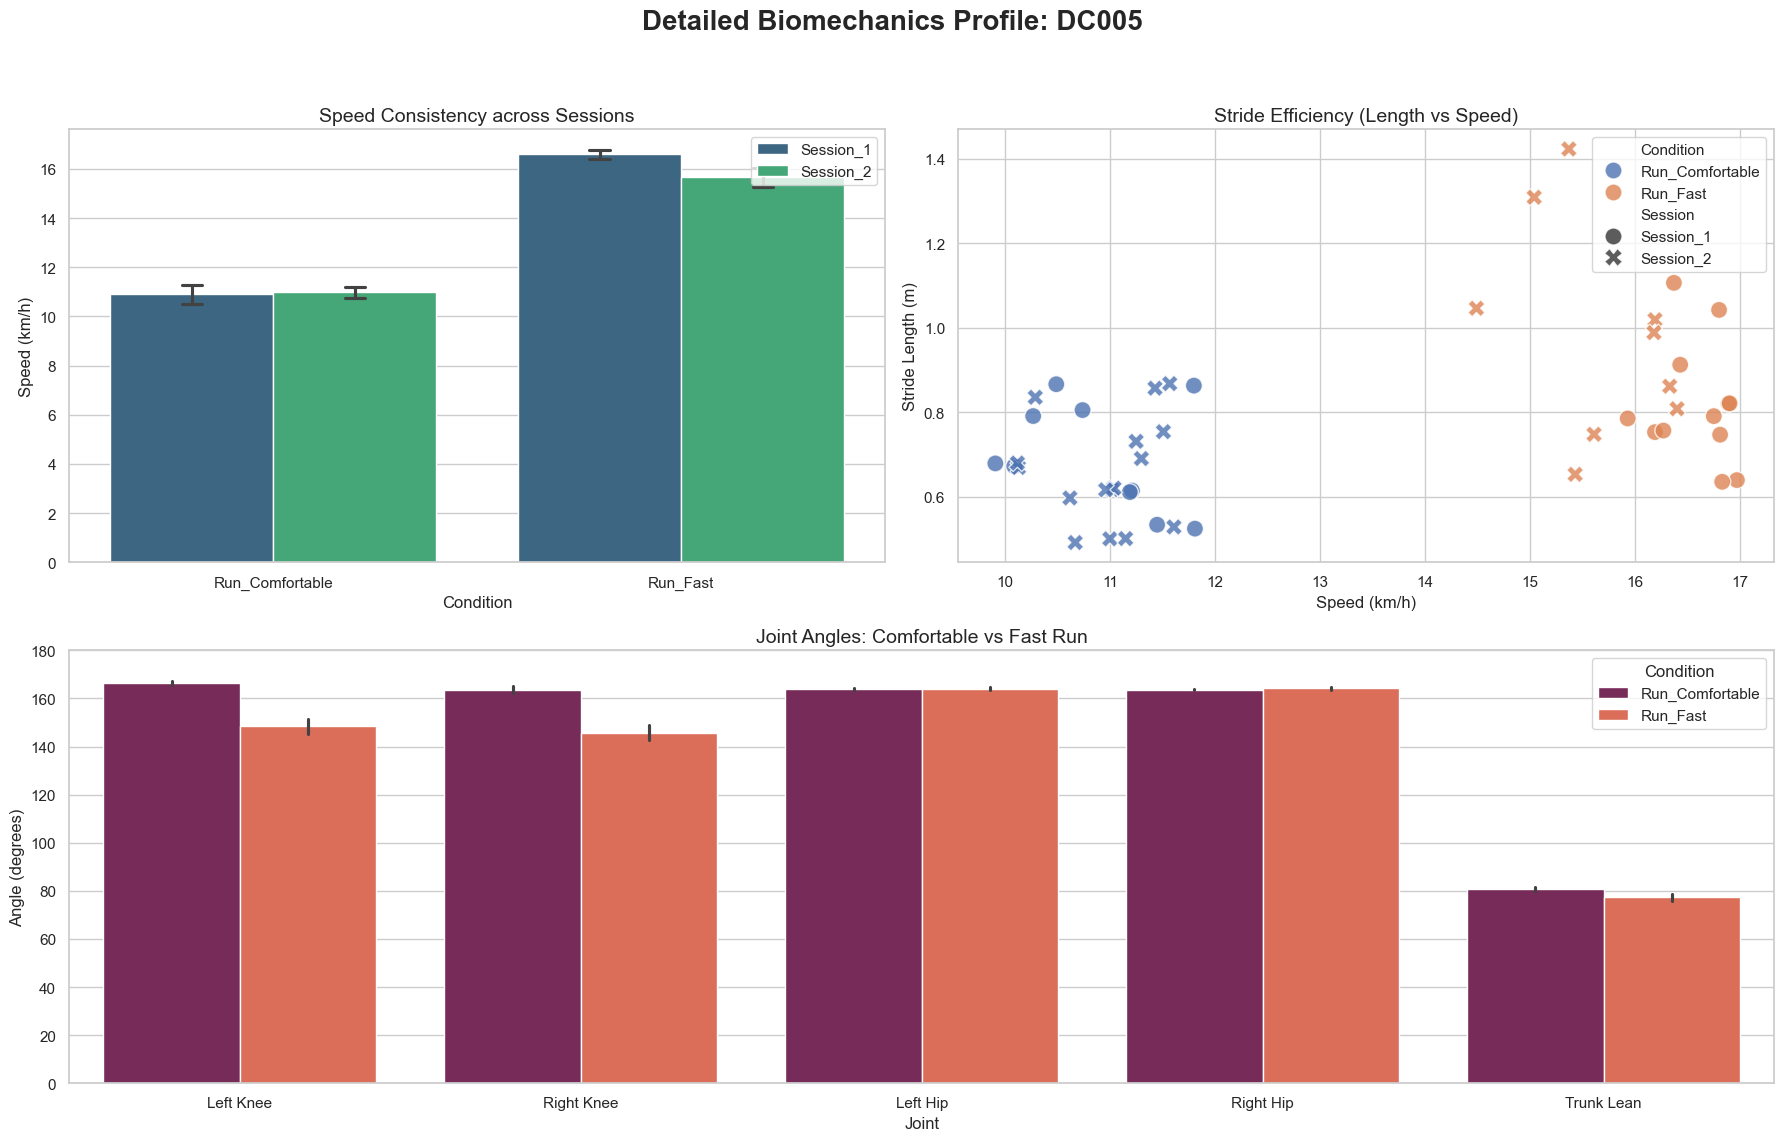

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_and_clean_data(filename):
    if not os.path.exists(filename):
        print(f"Error: {filename} not found.")
        return None

    df = pd.read_csv(filename)
    
    # Fix Negative Speeds & Stride Lengths
    numeric_cols_to_fix = ['Avg_Speed_kmh', 'Stride_Length_m']
    for col in numeric_cols_to_fix:
        if col in df.columns:
            df[col] = df[col].abs()

    return df

def plot_group_comparisons(df):
    """Generates boxplots comparing Gender and Conditions"""
    sns.set_theme(style="whitegrid")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Group Biomechanics Analysis', fontsize=20, fontweight='bold')

    # Metrics to plot
    metrics = [
        ('Avg_Speed_kmh', 'Running Speed (km/h)'),
        ('Cadence_spm', 'Cadence (steps/min)'),
        ('Stride_Length_m', 'Stride Length (m)'),
        ('Vert_Oscillation_mm', 'Vertical Oscillation (mm)')
    ]

    for i, (col, title) in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        # Boxplot with scatter overlay (stripplot) to show individual data points
        sns.boxplot(data=df, x='Condition', y=col, hue='Gender', ax=ax, palette="Set2", showfliers=False)
        sns.stripplot(data=df, x='Condition', y=col, hue='Gender', ax=ax, dodge=True, color='black', alpha=0.3, legend=False)
        
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('')
        ax.set_ylabel('')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('group_analysis_boxplots.png', dpi=300)
    print("Generated: group_analysis_boxplots.png")
    plt.show()

def plot_subject_detailed_dashboard(df, subject_id):
    """Generates a detailed 3-panel dashboard for a single subject"""
    
    # Filter data for specific subject
    sub_data = df[df['Subject_ID'] == subject_id].copy()
    
    if sub_data.empty:
        print(f"No data found for subject {subject_id}")
        return

    # Setup Grid Layout
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2)
    fig.suptitle(f'Detailed Biomechanics Profile: {subject_id}', fontsize=20, fontweight='bold')

    # 1. SPEED CONSISTENCY (Bar Plot with Error Bars)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(
        data=sub_data, x='Condition', y='Avg_Speed_kmh', hue='Session',
        palette='viridis', ax=ax1, capsize=0.1
    )
    ax1.set_title('Speed Consistency across Sessions', fontsize=14)
    ax1.set_ylabel('Speed (km/h)')
    ax1.legend(loc='upper right')

    # 2. EFFICIENCY (Scatter: Stride Length vs Speed)
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(
        data=sub_data, x='Avg_Speed_kmh', y='Stride_Length_m', 
        hue='Condition', style='Session', s=150, alpha=0.8, ax=ax2
    )
    ax2.set_title('Stride Efficiency (Length vs Speed)', fontsize=14)
    ax2.set_xlabel('Speed (km/h)')
    ax2.set_ylabel('Stride Length (m)')

    # 3. KINEMATICS (Joint Angles Comparison)
    ax3 = fig.add_subplot(gs[1, :])
    
    # Prepare angle data for plotting
    angle_cols = ['Left_Knee_Mean', 'Right_Knee_Mean', 'Left_Hip_Mean', 'Right_Hip_Mean', 'Trunk_Lean_Mean']
    # Check which exist
    valid_cols = [c for c in angle_cols if c in sub_data.columns]
    
    # Melt dataframe for Seaborn
    angle_data = sub_data.melt(
        id_vars=['Condition'], 
        value_vars=valid_cols, 
        var_name='Joint', 
        value_name='Angle'
    )
    
    # Clean Labels
    angle_data['Joint'] = angle_data['Joint'].str.replace('_Mean', '').str.replace('_', ' ')

    sns.barplot(
        data=angle_data, x='Joint', y='Angle', hue='Condition', 
        palette='rocket', ax=ax3
    )
    ax3.set_title('Joint Angles: Comfortable vs Fast Run', fontsize=14)
    ax3.set_ylabel('Angle (degrees)')
    ax3.set_ylim(0, 180) # Angles usually roughly 0-180
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'subject_{subject_id}_dashboard.png', dpi=300)
    print(f"Generated: subject_{subject_id}_dashboard.png")
    plt.show()

if __name__ == "__main__":
    file_path = 'CVIP\\Project\\testing\\running_biomechanics_results.csv'
    
    df = load_and_clean_data(file_path)
    
    if df is not None:
        # 1. Run Group Analysis
        plot_group_comparisons(df)
        
        # 2. Run Detailed Subject Analysis
        # Automatically pick the first subject in the list to analyze
        first_subject = df['Subject_ID'].unique()[6]
        plot_subject_detailed_dashboard(df, first_subject)

Calculated BMI (kg/m²) for all subjects.


C:\Users\Admin\AppData\Local\Temp\ipykernel_20100\2965217941.py:55: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df, x='Condition', y=col, hue='Gender', ax=ax, dodge=True, color='black', alpha=0.3, legend=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20100\2965217941.py:55: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df, x='Condition', y=col, hue='Gender', ax=ax, dodge=True, color='black', alpha=0.3, legend=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20100\2965217941.py:55: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df, x='Condition', y=col, hue='Gender', ax=ax, dodge=True, color='black', alpha

Generated: group_analysis_boxplots.png
Generated: analysis_age.png


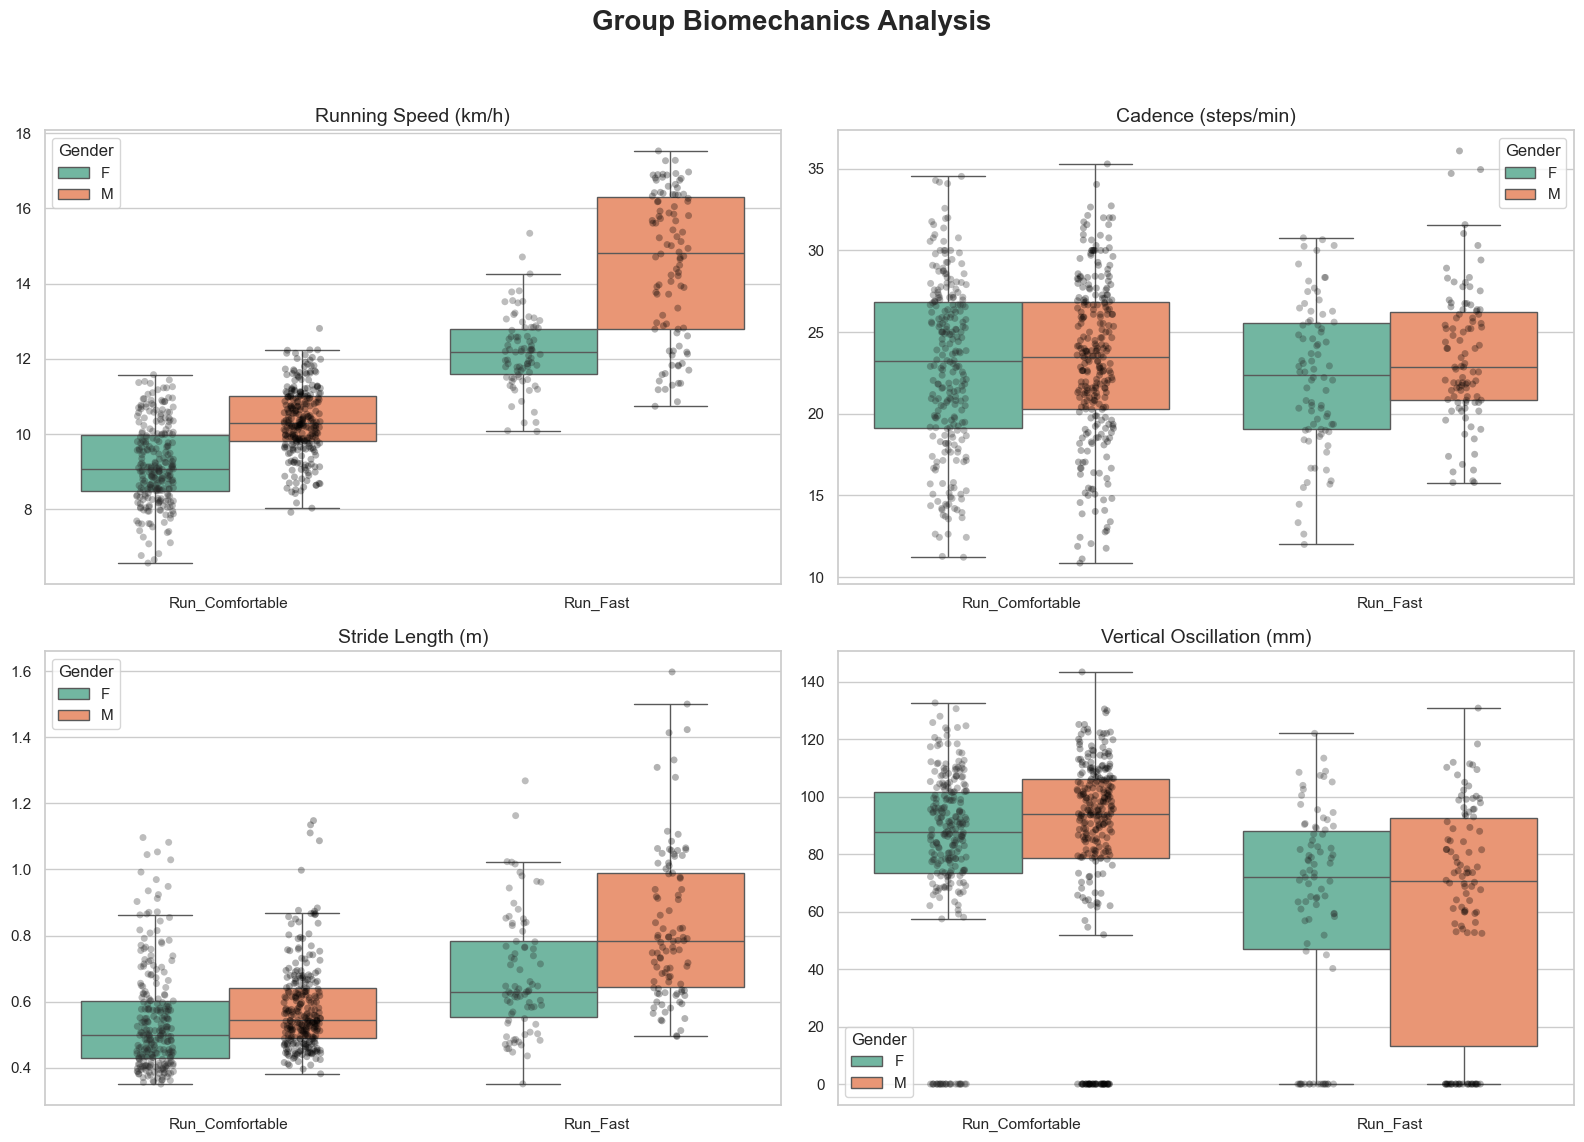

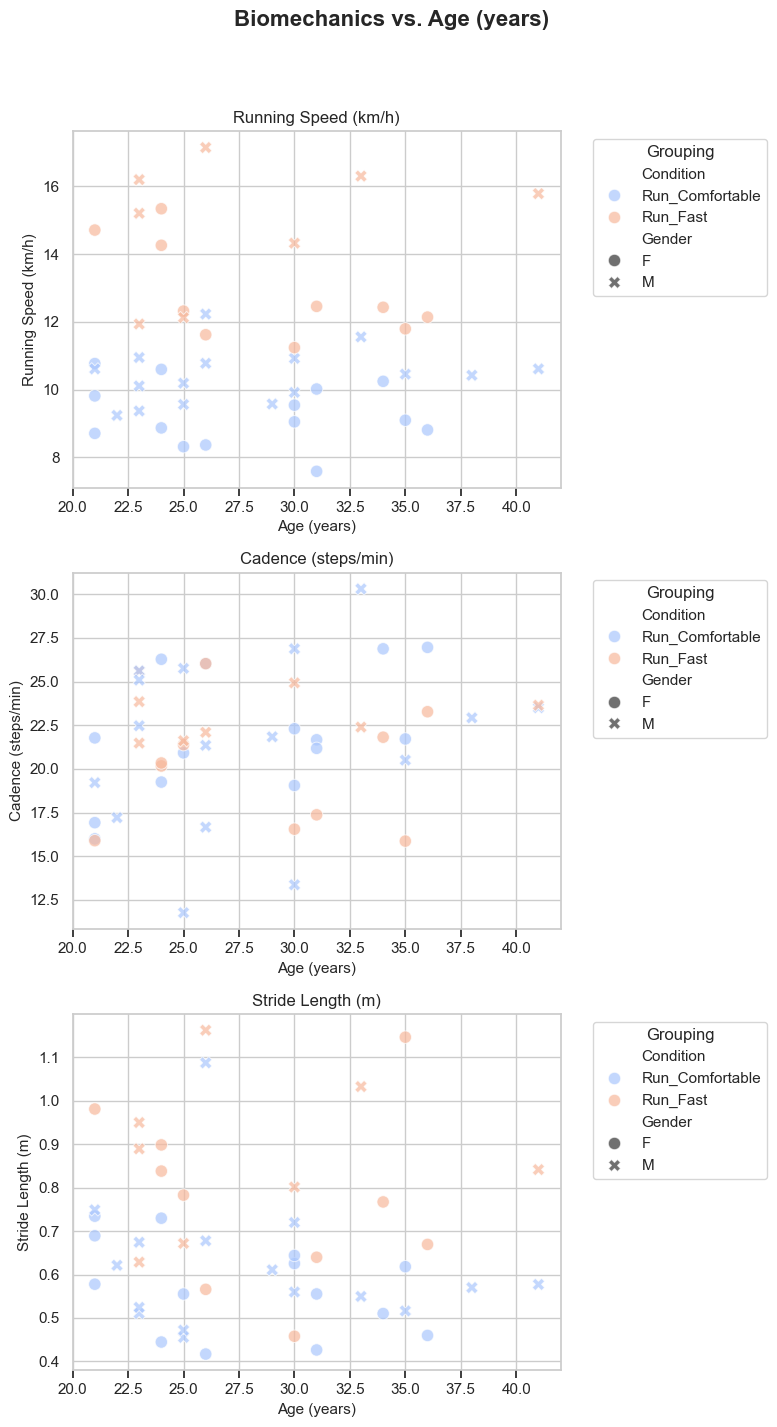

Generated: analysis_bodymass.png


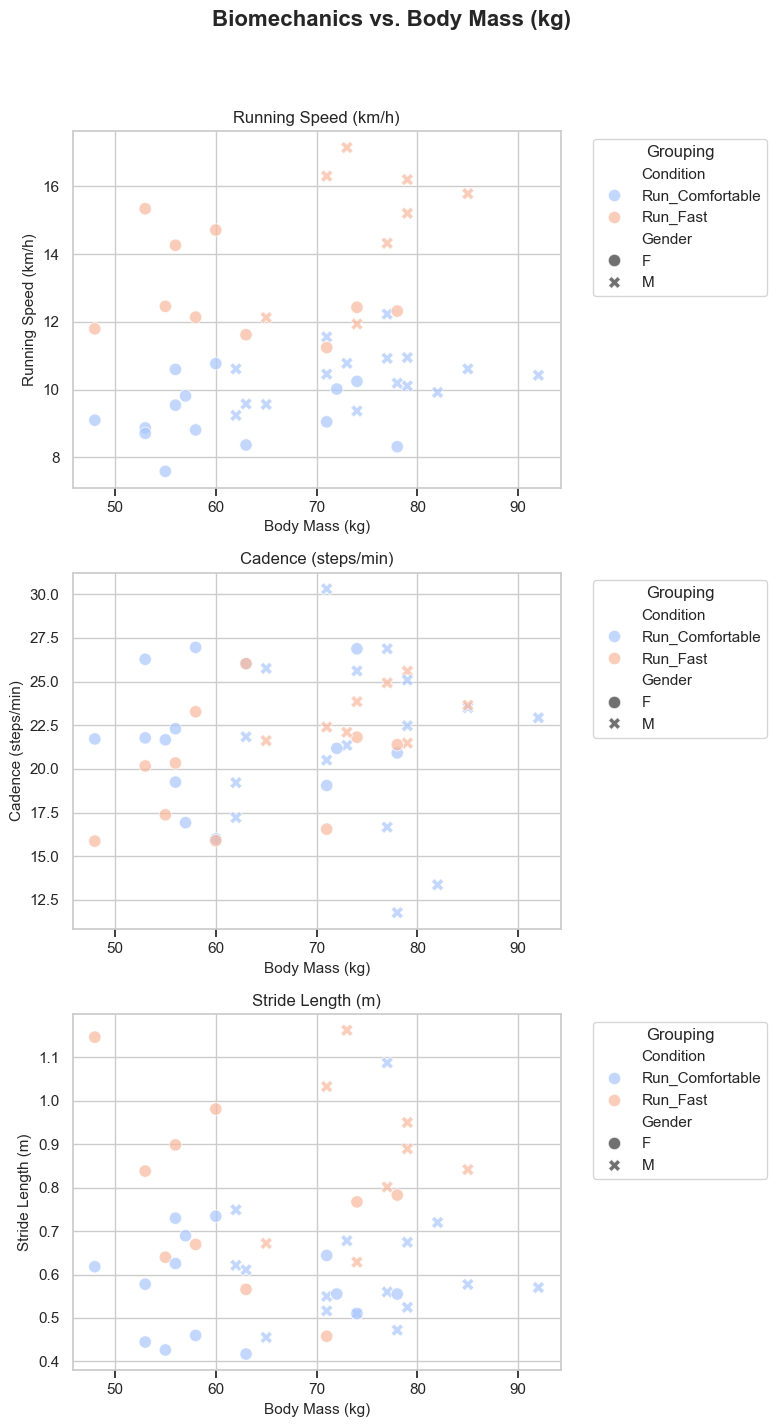

Generated: analysis_height.png


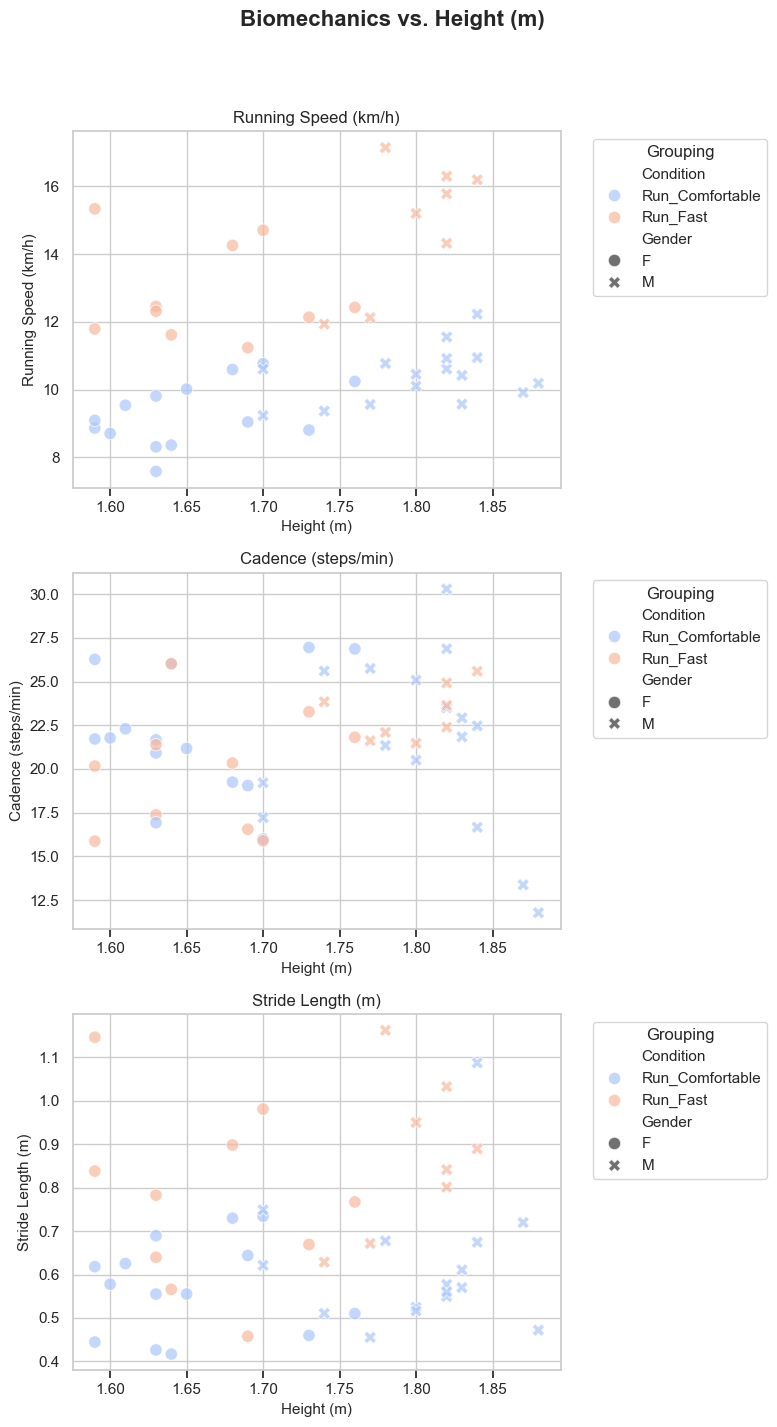

Generated: analysis_bmi.png


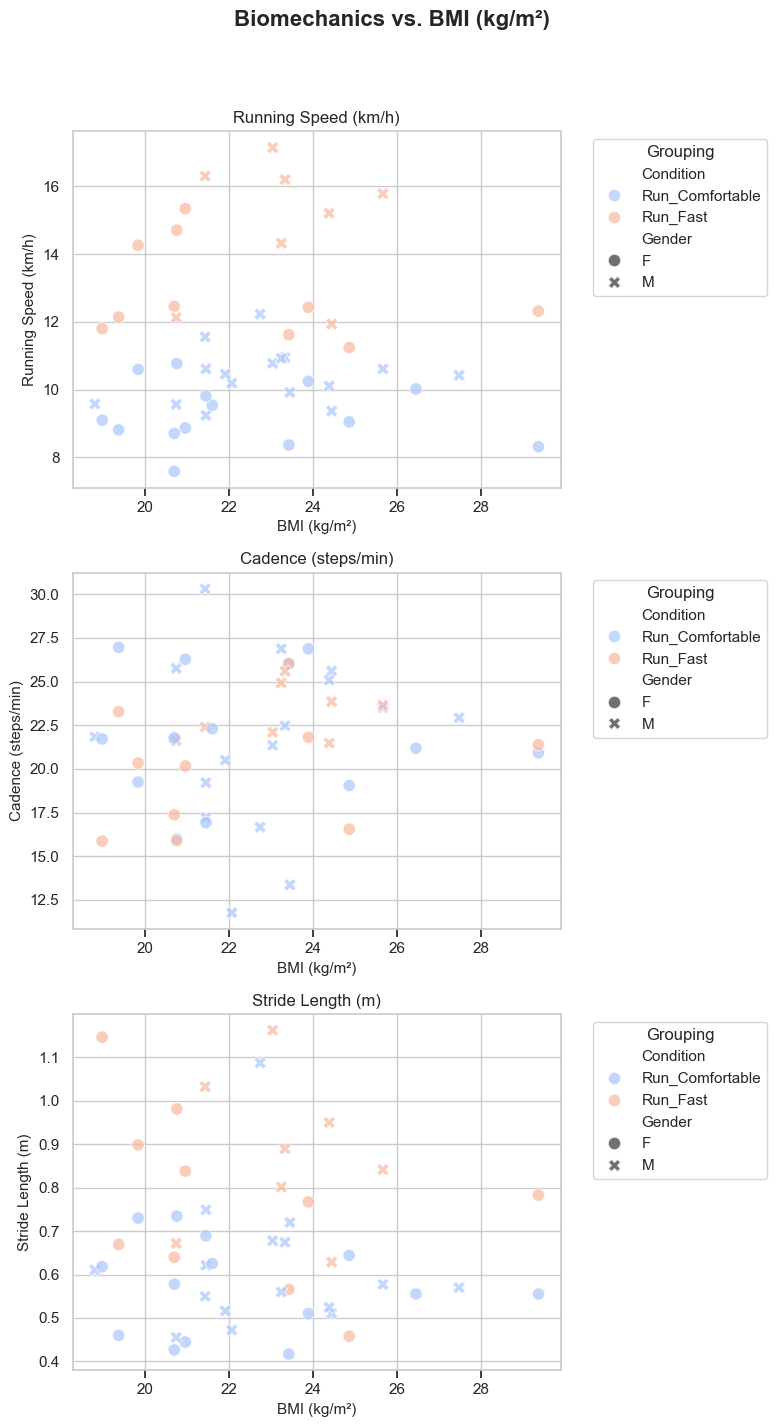

Generated: subject_DC005_dashboard.png


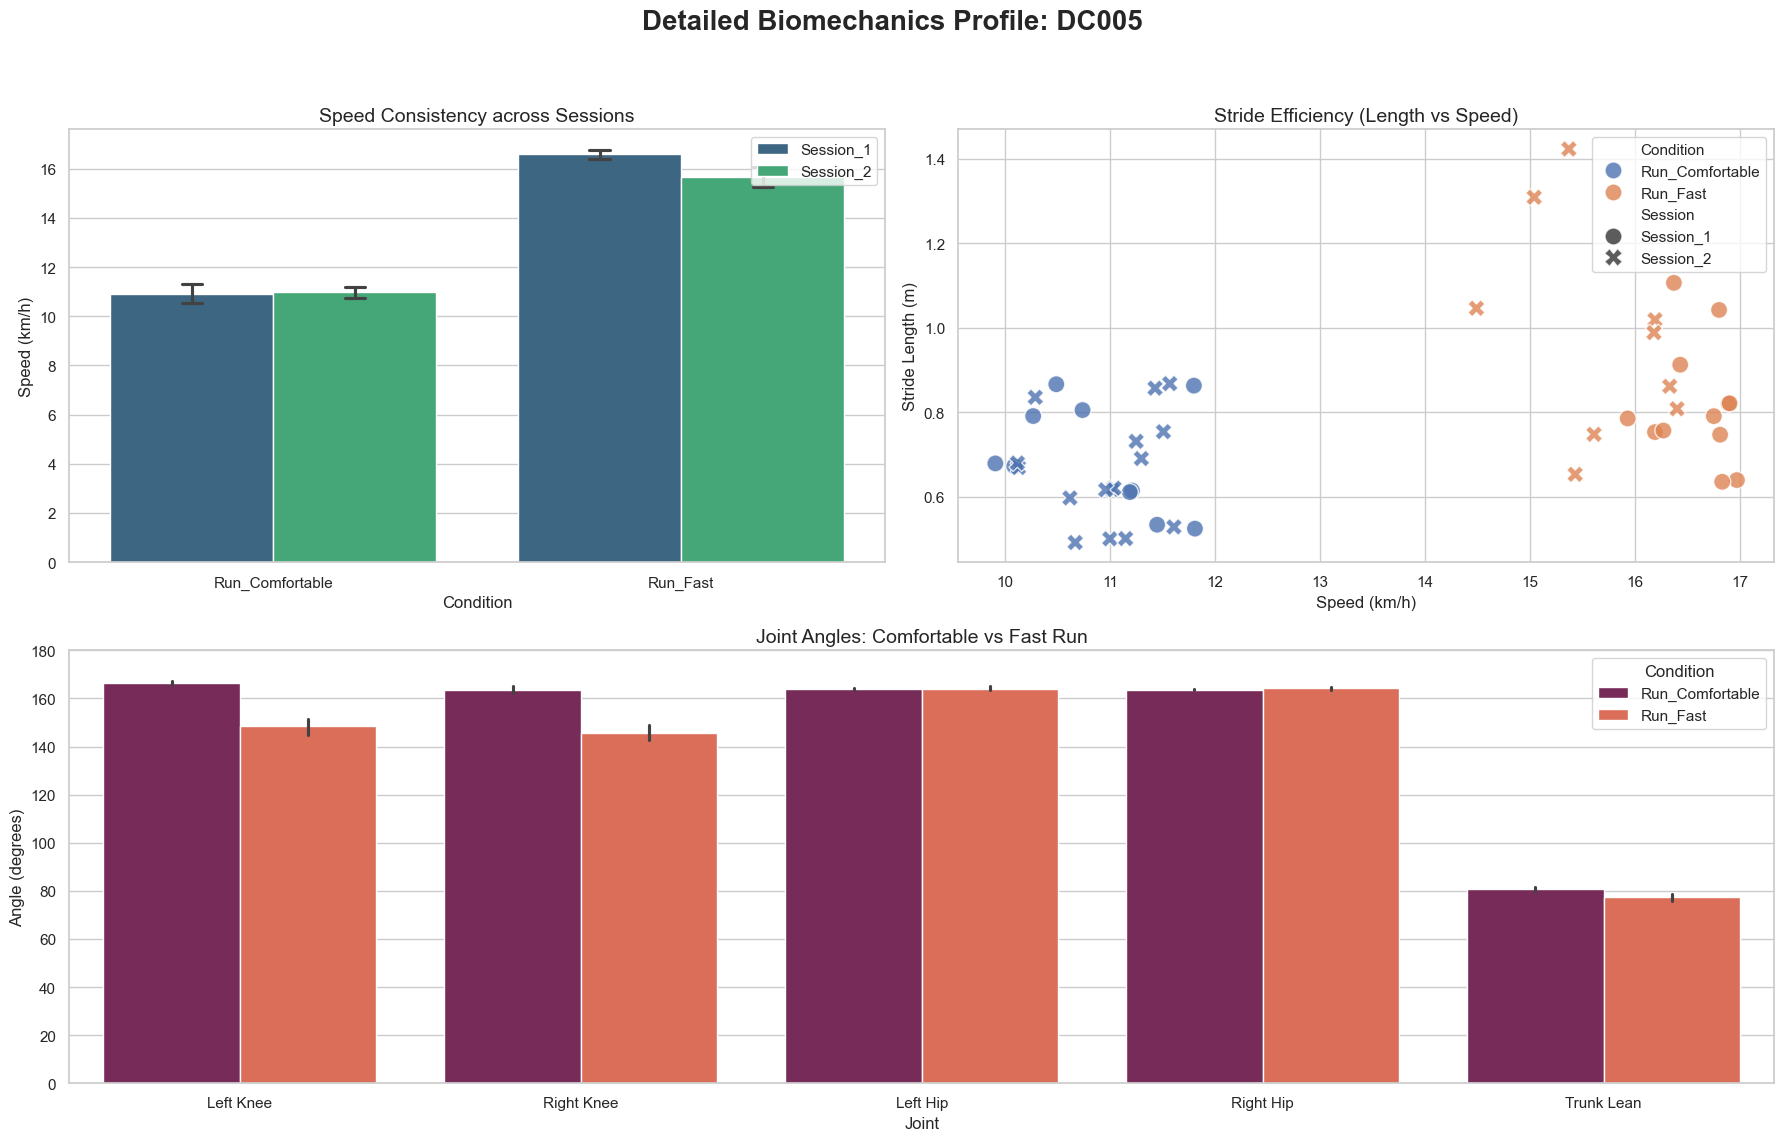

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_and_clean_data(filename):
    if not os.path.exists(filename):
        print(f"Error: {filename} not found.")
        return None

    df = pd.read_csv(filename)
    
    # Fix Negative Speeds & Stride Lengths
    numeric_cols_to_fix = ['Avg_Speed_kmh', 'Stride_Length_m']
    for col in numeric_cols_to_fix:
        if col in df.columns:
            df[col] = df[col].abs()

    # **NEW: Anthropometrics and BMI Calculation**
    # Assume Bodymass is in kg and Height is in mm
    if 'Bodymass' in df.columns and 'Height' in df.columns:
        # 1. Convert Height from mm to meters
        df['Height_m'] = df['Height'] / 1000
        
        # 2. Calculate BMI: BMI = Mass (kg) / Height (m)^2
        # Use .loc to avoid SettingWithCopyWarning
        df.loc[:, 'BMI'] = df['Bodymass'] / (df['Height_m'] ** 2)
        
        # Clean up intermediate height column if desired (keeping it for reference)
        # df = df.drop(columns=['Height_m'])
        print("Calculated BMI (kg/m²) for all subjects.")
        
    return df

def plot_group_comparisons(df):
    """Generates boxplots comparing Gender and Conditions"""
    sns.set_theme(style="whitegrid")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Group Biomechanics Analysis', fontsize=20, fontweight='bold')

    # Metrics to plot
    metrics = [
        ('Avg_Speed_kmh', 'Running Speed (km/h)'),
        ('Cadence_spm', 'Cadence (steps/min)'),
        ('Stride_Length_m', 'Stride Length (m)'),
        ('Vert_Oscillation_mm', 'Vertical Oscillation (mm)')
    ]

    for i, (col, title) in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        # Boxplot with scatter overlay (stripplot) to show individual data points
        sns.boxplot(data=df, x='Condition', y=col, hue='Gender', ax=ax, palette="Set2", showfliers=False)
        sns.stripplot(data=df, x='Condition', y=col, hue='Gender', ax=ax, dodge=True, color='black', alpha=0.3, legend=False)
        
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('')
        ax.set_ylabel('')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('group_analysis_boxplots.png', dpi=300)
    print("Generated: group_analysis_boxplots.png")
    # plt.show() # Disabled for cleaner execution in a script environment

def plot_age_analysis(df):
    """Generates scatter plots comparing biomechanics against Age."""
    if 'Age' not in df.columns:
        print("Age column not found. Skipping Age analysis.")
        return
        
    agg_df = df.groupby(['Subject_ID', 'Condition', 'Gender']).agg(
        Age=('Age', 'first'),
        Avg_Speed_kmh=('Avg_Speed_kmh', 'mean'),
        Cadence_spm=('Cadence_spm', 'mean'),
        Stride_Length_m=('Stride_Length_m', 'mean'),
    ).reset_index()

    sns.set_theme(style="whitegrid")
    
    y_metrics = [
        ('Avg_Speed_kmh', 'Running Speed (km/h)'),
        ('Cadence_spm', 'Cadence (steps/min)'),
        ('Stride_Length_m', 'Stride Length (m)')
    ]

    fig, axes = plt.subplots(3, 1, figsize=(8, 15))
    fig.suptitle('Biomechanics vs. Age (years)', fontsize=16, fontweight='bold')
    
    for i, (y_col, y_title) in enumerate(y_metrics):
        ax = axes[i]
        sns.scatterplot(
            data=agg_df, 
            x='Age', 
            y=y_col, 
            hue='Condition', 
            style='Gender', 
            s=80, 
            alpha=0.7,
            palette='coolwarm',
            ax=ax
        )
        ax.set_title(y_title, fontsize=12)
        ax.set_ylabel(y_title, fontsize=11)
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
        ax.set_xlabel('Age (years)', fontsize=11)
        ax.legend(title='Grouping', bbox_to_anchor=(1.05, 1), loc='upper left')

    # axes[-1].set_xlabel('Age (years)', fontsize=11)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('analysis_age.png', dpi=300)
    print("Generated: analysis_age.png")
    plt.show()

# --- NEW FUNCTION FOR BODY MASS ANALYSIS ---
def plot_bodymass_analysis(df):
    """Generates scatter plots comparing biomechanics against Body Mass."""
    if 'Bodymass' not in df.columns:
        print("Bodymass column not found. Skipping Body Mass analysis.")
        return
        
    agg_df = df.groupby(['Subject_ID', 'Condition', 'Gender']).agg(
        Bodymass=('Bodymass', 'first'),
        Avg_Speed_kmh=('Avg_Speed_kmh', 'mean'),
        Cadence_spm=('Cadence_spm', 'mean'),
        Stride_Length_m=('Stride_Length_m', 'mean'),
    ).reset_index()

    sns.set_theme(style="whitegrid")
    
    y_metrics = [
        ('Avg_Speed_kmh', 'Running Speed (km/h)'),
        ('Cadence_spm', 'Cadence (steps/min)'),
        ('Stride_Length_m', 'Stride Length (m)')
    ]

    fig, axes = plt.subplots(3, 1, figsize=(8, 15))
    fig.suptitle('Biomechanics vs. Body Mass (kg)', fontsize=16, fontweight='bold')
    
    for i, (y_col, y_title) in enumerate(y_metrics):
        ax = axes[i]
        sns.scatterplot(
            data=agg_df, 
            x='Bodymass', 
            y=y_col, 
            hue='Condition', 
            style='Gender', 
            s=80, 
            alpha=0.7,
            palette='coolwarm',
            ax=ax
        )
        ax.set_title(y_title, fontsize=12)
        ax.set_ylabel(y_title, fontsize=11)
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
        ax.set_xlabel('Body Mass (kg)', fontsize=11)
        ax.legend(title='Grouping', bbox_to_anchor=(1.05, 1), loc='upper left')

    # axes[-1].set_xlabel('Body Mass (kg)', fontsize=11)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('analysis_bodymass.png', dpi=300)
    print("Generated: analysis_bodymass.png")
    plt.show()

# --- NEW FUNCTION FOR HEIGHT ANALYSIS ---
def plot_height_analysis(df):
    """Generates scatter plots comparing biomechanics against Height."""
    if 'Height_m' not in df.columns:
        print("Height_m column not found. Skipping Height analysis.")
        return
        
    agg_df = df.groupby(['Subject_ID', 'Condition', 'Gender']).agg(
        Height_m=('Height_m', 'first'),
        Avg_Speed_kmh=('Avg_Speed_kmh', 'mean'),
        Cadence_spm=('Cadence_spm', 'mean'),
        Stride_Length_m=('Stride_Length_m', 'mean'),
    ).reset_index()

    sns.set_theme(style="whitegrid")
    
    y_metrics = [
        ('Avg_Speed_kmh', 'Running Speed (km/h)'),
        ('Cadence_spm', 'Cadence (steps/min)'),
        ('Stride_Length_m', 'Stride Length (m)')
    ]

    fig, axes = plt.subplots(3, 1, figsize=(8, 15))
    fig.suptitle('Biomechanics vs. Height (m)', fontsize=16, fontweight='bold')
    
    for i, (y_col, y_title) in enumerate(y_metrics):
        ax = axes[i]
        sns.scatterplot(
            data=agg_df, 
            x='Height_m', 
            y=y_col, 
            hue='Condition', 
            style='Gender', 
            s=80, 
            alpha=0.7,
            palette='coolwarm',
            ax=ax
        )
        ax.set_title(y_title, fontsize=12)
        ax.set_ylabel(y_title, fontsize=11)
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
        ax.set_xlabel('Height (m)', fontsize=11)
        ax.legend(title='Grouping', bbox_to_anchor=(1.05, 1), loc='upper left')

    # axes[-1].set_xlabel('Height (m)', fontsize=11)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('analysis_height.png', dpi=300)
    print("Generated: analysis_height.png")
    plt.show()

# --- NEW FUNCTION FOR BMI ANALYSIS ---
def plot_bmi_analysis(df):
    """Generates scatter plots comparing biomechanics against BMI."""
    if 'BMI' not in df.columns:
        print("BMI column not found. Skipping BMI analysis.")
        return
        
    agg_df = df.groupby(['Subject_ID', 'Condition', 'Gender']).agg(
        BMI=('BMI', 'first'),
        Avg_Speed_kmh=('Avg_Speed_kmh', 'mean'),
        Cadence_spm=('Cadence_spm', 'mean'),
        Stride_Length_m=('Stride_Length_m', 'mean'),
    ).reset_index()

    sns.set_theme(style="whitegrid")
    
    y_metrics = [
        ('Avg_Speed_kmh', 'Running Speed (km/h)'),
        ('Cadence_spm', 'Cadence (steps/min)'),
        ('Stride_Length_m', 'Stride Length (m)')
    ]

    fig, axes = plt.subplots(3, 1, figsize=(8, 15))
    fig.suptitle('Biomechanics vs. BMI (kg/m²)', fontsize=16, fontweight='bold')
    
    for i, (y_col, y_title) in enumerate(y_metrics):
        ax = axes[i]
        sns.scatterplot(
            data=agg_df, 
            x='BMI', 
            y=y_col, 
            hue='Condition', 
            style='Gender', 
            s=80, 
            alpha=0.7,
            palette='coolwarm',
            ax=ax
        )
        ax.set_title(y_title, fontsize=12)
        ax.set_ylabel(y_title, fontsize=11)
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
        ax.set_xlabel('BMI (kg/m²)', fontsize=11)
        ax.legend(title='Grouping', bbox_to_anchor=(1.05, 1), loc='upper left')

    # axes[-1].set_xlabel('BMI (kg/m²)', fontsize=11)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('analysis_bmi.png', dpi=300)
    print("Generated: analysis_bmi.png")
    plt.show()


def plot_subject_detailed_dashboard(df, subject_id):
    """Generates a detailed 3-panel dashboard for a single subject"""
    
    # Filter data for specific subject
    sub_data = df[df['Subject_ID'] == subject_id].copy()
    
    if sub_data.empty:
        print(f"No data found for subject {subject_id}")
        return

    # Setup Grid Layout
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2)
    fig.suptitle(f'Detailed Biomechanics Profile: {subject_id}', fontsize=20, fontweight='bold')

    # 1. SPEED CONSISTENCY (Bar Plot with Error Bars)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(
        data=sub_data, x='Condition', y='Avg_Speed_kmh', hue='Session',
        palette='viridis', ax=ax1, capsize=0.1
    )
    ax1.set_title('Speed Consistency across Sessions', fontsize=14)
    ax1.set_ylabel('Speed (km/h)')
    ax1.legend(loc='upper right')

    # 2. EFFICIENCY (Scatter: Stride Length vs Speed)
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(
        data=sub_data, x='Avg_Speed_kmh', y='Stride_Length_m', 
        hue='Condition', style='Session', s=150, alpha=0.8, ax=ax2
    )
    ax2.set_title('Stride Efficiency (Length vs Speed)', fontsize=14)
    ax2.set_xlabel('Speed (km/h)')
    ax2.set_ylabel('Stride Length (m)')

    # 3. KINEMATICS (Joint Angles Comparison)
    ax3 = fig.add_subplot(gs[1, :])
    
    # Prepare angle data for plotting
    angle_cols = ['Left_Knee_Mean', 'Right_Knee_Mean', 'Left_Hip_Mean', 'Right_Hip_Mean', 'Trunk_Lean_Mean']
    # Check which exist
    valid_cols = [c for c in angle_cols if c in sub_data.columns]
    
    # Melt dataframe for Seaborn
    angle_data = sub_data.melt(
        id_vars=['Condition'], 
        value_vars=valid_cols, 
        var_name='Joint', 
        value_name='Angle'
    )
    
    # Clean Labels
    angle_data['Joint'] = angle_data['Joint'].str.replace('_Mean', '').str.replace('_', ' ')

    sns.barplot(
        data=angle_data, x='Joint', y='Angle', hue='Condition', 
        palette='rocket', ax=ax3
    )
    ax3.set_title('Joint Angles: Comfortable vs Fast Run', fontsize=14)
    ax3.set_ylabel('Angle (degrees)')
    ax3.set_ylim(0, 180) # Angles usually roughly 0-180
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'subject_{subject_id}_dashboard.png', dpi=300)
    print(f"Generated: subject_{subject_id}_dashboard.png")
    # plt.show() # Disabled for cleaner execution

if __name__ == "__main__":
    file_path = 'CVIP\\Project\\testing\\running_biomechanics_results.csv'
    
    df = load_and_clean_data(file_path)
    
    if df is not None:
        # 1. Run Group Analysis
        plot_group_comparisons(df)
        
        plot_age_analysis(df)
        plot_bodymass_analysis(df)
        plot_height_analysis(df)
        plot_bmi_analysis(df)
        
        # 3. Run Detailed Subject Analysis
        # Automatically pick the sixth subject in the list to analyze
        # Check if there are enough subjects before accessing index 6
        if len(df['Subject_ID'].unique()) > 6:
            first_subject = df['Subject_ID'].unique()[6]
            plot_subject_detailed_dashboard(df, first_subject)
        elif len(df['Subject_ID'].unique()) > 0:
            first_subject = df['Subject_ID'].unique()[0]
            plot_subject_detailed_dashboard(df, first_subject)
        else:
            print("Not enough unique subjects to run detailed dashboard analysis.")